# Pendulum Example

In this example we go from generating raw simulation data through extracting the generators of the underlying potential using SymDet.

In [1]:
import symdet
from symdet.utils.data_clustering import range_binning
import hephaestus as hp
import numpy as np
import tensorflow as tf
import copy
import matplotlib.pyplot as plt

### Generating the Data

First things first, we need to generate some data to use in the symmetry extraction. We have a pendulum swinging ideally with an angle for 4.0 degrees.

In [2]:
pendulum = hp.SinglePendulum(time_step=0.001, steps=50000, mass=1.0, gravity=10.0, theta_start=5.0)
integrator = hp.VelocityVerlet(time_step=0.001, model=pendulum)
pendulum.integrator = integrator  # update the integrator

In [3]:
pendulum.run_simulation()  # seperated to avoid unnecesary running of simulations.

100%|█████████████████████████| 49999/49999 [00:27<00:00, 1838.17it/s]


Before rushing into clustering and generator studies we should spend some time looking at the data that has been generated.

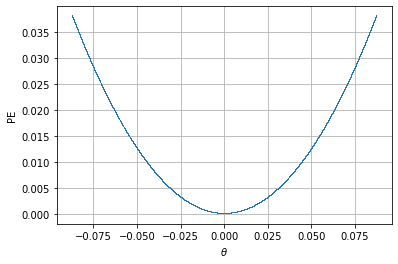

In [4]:
plt.plot(pendulum.theta, pendulum.pe, ',')
plt.grid()
plt.xlabel(r'$\theta$')
plt.ylabel('PE')
plt.show()

### Clustering the Data

In [5]:
x_data = pendulum.length * np.sin(pendulum.theta)
y_data = pendulum.length * np.cos(pendulum.theta)
domain = tf.convert_to_tensor(list(zip(x_data, y_data)))
image = tf.convert_to_tensor(pendulum.pe / max(pendulum.pe))

In [6]:
clustered_data = range_binning(image=image,
              domain=domain,
              value_range=[0, 3],
              bin_operation=[1 / 5, 0.008],
              representatives=500)

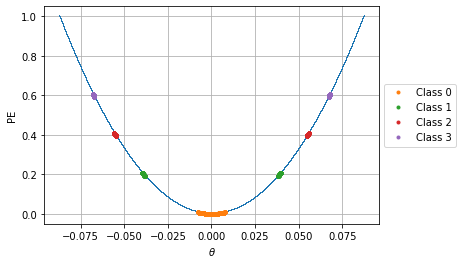

In [7]:
plt.plot(pendulum.theta, pendulum.pe / max(pendulum.pe), ',')
plt.grid()
plt.xlabel(r'$\theta$')
plt.ylabel('PE')

for i, item in enumerate(clustered_data):
    theta = np.arcsin(clustered_data[item]['domain'][:, 0]) / pendulum.length
    v = clustered_data[item]['image']
    plt.plot(theta, v, '.', label=f"Class {i}", markersize=6)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Detecting Symmetry Groups

In [8]:
model = symdet.DenseModel(n_layers=7,
                          units=80,
                          epochs=10,
                          batch_size=64,
                          lr=0.00025)

In [9]:
sym_detector = symdet.GroupDetection(model, clustered_data)

### A quick sanity check

At this stage we need to stop and check that we have collected some group data on which to extract generators. We do this by looking at the keys of the point_cloud and seeing if they look good when compared to the tSNE representation.

In [11]:
point_cloud.keys()

dict_keys([1.0])

In this case, the points selected are from groups 1.0, 2.0, and 3.0, which, by looking at both the tSNE representation and the cluster image above, looks correct. However, it is also very possible that we are now missing data that is also clearly clustered. This is due to the pair detection algorithm being used as is currently being re-evaluated and improved. For now, if you want to make the code more sensitive to pairs in the tSNE representation you can do so in the source code.

Producing generator candidates: 100%|█████████████████████████████████| 5/5 [06:05<00:00, 73.00s/it]

Principle Component 1: Explained Variance: 1.0
[[ 3.96040687e-04  4.03361962e-04]
 [-9.99999807e-01 -2.56381583e-04]]


Principle Component 2: Explained Variance: 1.9333975529184653e-39
[[6.48179537e-01 6.60161894e-01]
 [4.25683098e-04 3.79538379e-01]]


Principle Component 3: Explained Variance: 6.512479373171105e-72
[[-2.66043536e-01 -2.70684524e-01]
 [-4.51746065e-04  9.25175941e-01]]


Principle Component 4: Explained Variance: 0.0
[[ 7.13501204e-01 -7.00653980e-01]
 [-8.77122949e-08  1.79634780e-04]]




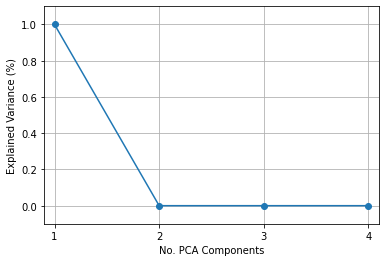

In [13]:
generator_list = {}
for item in point_cloud:
    try:
        generator_list[item] = {}
        generator_extractor = symdet.GeneratorExtraction(
                              point_cloud[item],  # clustered data
                              delta=0.5,         # distance of points to hyperplane
                              epsilon=0.3,       # distance between points connected by a generator
                              candidate_runs=5   # Number of times to run the extraction loop
                            ) 
        generators, variance_list = generator_extractor.perform_generator_extraction(pca_components=4,
                                                                                     plot=True,
                                                                                     factor=False
                                                                                     gs_precision=3)
        generator_list[item]['generators'] = generators
        generator_list[item]['variance'] = variance_list
    except ValueError:
        print(f"No generator found for {item}")
        continue

There are a few interesting points to go through here. The first, and most important, is the final plot. We can see that the code has produced a single relevant generator matrix suggesting that the space was correctly defined. The second point is the actual generator that was found. We can see that is appears to only cotain one dominant points, i.e. the -1 in the in the lower left corner of the matrix. This is not exactly what one would expect to see in tru SO(2) symmetry but considering that the energy is only indirectly influence by the x-position it is not unlikely that the generator is reduced to only a single number.